<a href="https://colab.research.google.com/github/Deleon57/EDAR-Data/blob/main/RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import datetime as dt
import pandas as pd
from pandas_datareader import data as pdr
from google.colab import files
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [8]:
stocklist = ['GFI', 'FSR']
stocks = [i + '.JO' for i in stocklist]
stocks

['GFI.JO', 'FSR.JO']

In [9]:
start = "2013-03-01"
end = "2024-02-28"
df = yf.download(['GFI.JO', 'FSR.JO'], start=start, end=end)

df.head()

/tmp/ipython-input-771001001.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(['GFI.JO', 'FSR.JO'], start=start, end=end)
[*********************100%***********************]  2 of 2 completed


Price             Close                      High                       Low  \
Ticker           FSR.JO       GFI.JO       FSR.JO       GFI.JO       FSR.JO   
Date                                                                          
2013-03-01  3121.474121  7431.278809  3132.409222  7503.097879  3062.822219   
2013-03-04  3064.810547  7250.466797  3126.444752  7385.141125  3032.005244   
2013-03-05  3201.001953  7257.449219  3201.001953  7283.386494  3083.698155   
2013-03-06  3107.557129  6928.246582  3220.884548  7299.349207  3105.568929   
2013-03-07  3114.515625  7453.975098  3156.267829  7503.854481  3095.627723   

Price                           Open                 Volume            
Ticker           GFI.JO       FSR.JO       GFI.JO    FSR.JO    GFI.JO  
Date                                                                   
2013-03-01  7338.512509  3084.692420  7465.193370  12379894   5930842  
2013-03-04  7250.466797  3126.444752  7370.177311  14174847   4128626  
2013-03-05  7217.545718  3100.597855  7262.437156  16391688   5666832  
2013-03-06  6928.246582  3202.990745  7258.448111  18189945   6130247  
2013-03-07  7237.498572  3132.409427  7282.390018  18272095  10489933

In [4]:
Close = df['Close']
Close.head()

Ticker,FSR.JO,GFI.JO
Date,,
2013-03-01,3121.474121,7431.278809
2013-03-04,3064.810547,7250.466797
2013-03-05,3201.001953,7257.449219
2013-03-06,3107.557129,6928.246582
2013-03-07,3114.515625,7453.975098


In [5]:
gfi_close = Close['GFI.JO']

gfi_close = pd.DataFrame(gfi_close)
gfi_close['Target'] = (gfi_close['GFI.JO'].shift(-1) > gfi_close['GFI.JO']).astype(int)
gfi_close.dropna(inplace=True)

display(gfi_close.head())

,GFI.JO,Target
Date,,
2013-03-01,7431.278809,0
2013-03-04,7250.466797,1
2013-03-05,7257.449219,0
2013-03-06,6928.246582,1
2013-03-07,7453.975098,0


In [10]:
X = gfi_close[['GFI.JO']] # Features (the stock price itself)
y = gfi_close['Target'] # Target variable (whether the price goes up or down)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)

Training data shape: (2237, 1) (2237,)
Testing data shape: (560, 1) (560,)


In [11]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

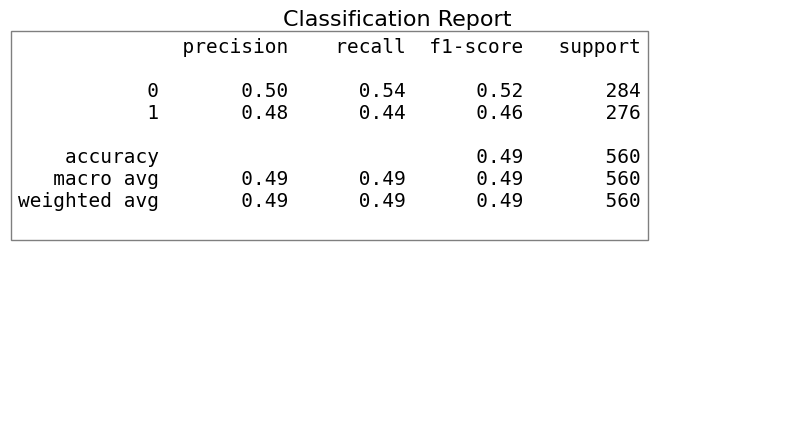

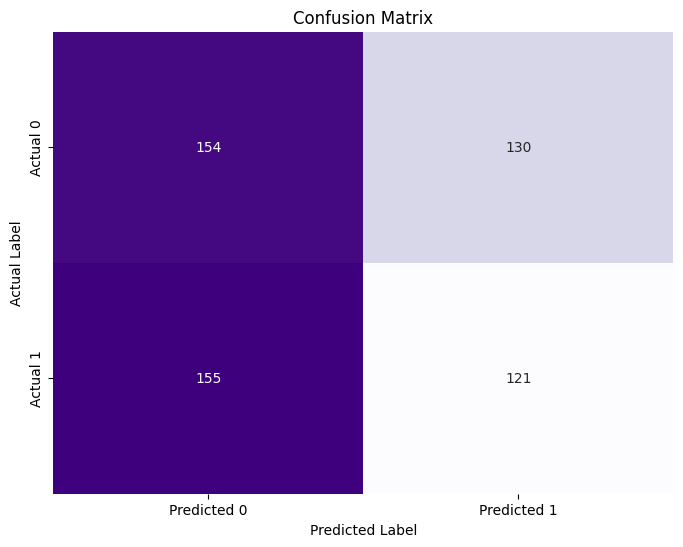

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Display Classification Report with larger text
plt.figure(figsize=(10, 5)) # Adjust figure size for the text output
plt.text(0.01, 0.99, class_report, {'fontsize': 14}, fontfamily='monospace',
         ha='left', va='top', bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 5})
plt.axis('off')
plt.title('Classification Report', fontsize=16)
plt.show()

# Display Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

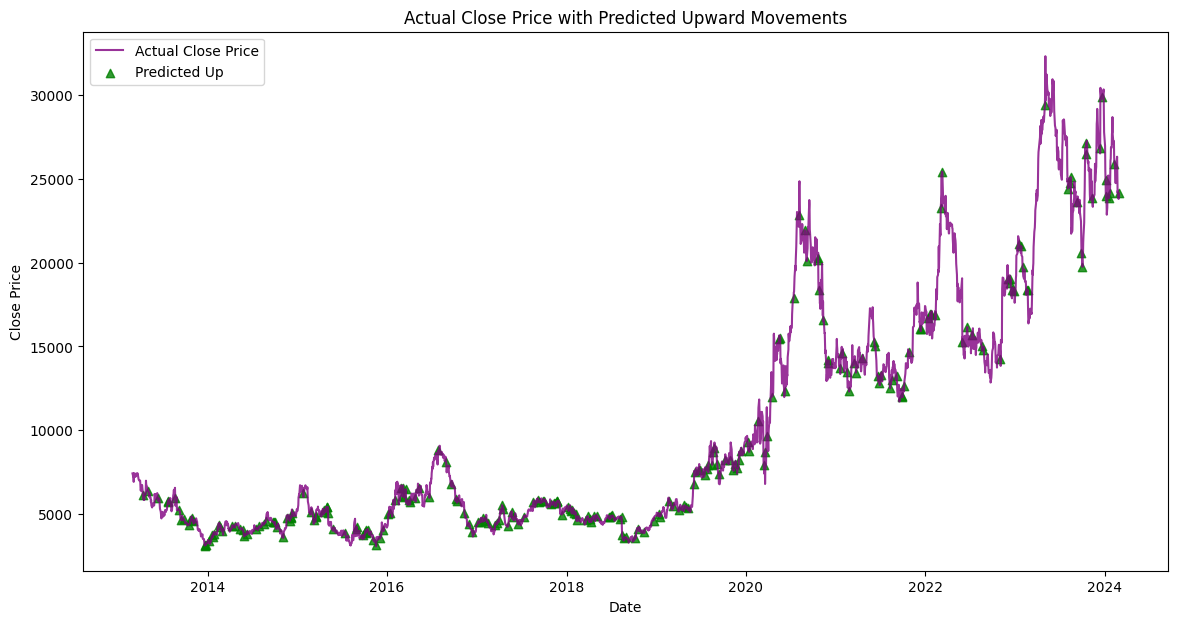

In [18]:
plt.figure(figsize=(14, 7))
plt.plot(gfi_close.index, gfi_close['GFI.JO'], label='Actual Close Price', alpha=0.8, color='purple')

# Highlight points where the model predicted an upward movement (Predicted = 1)
predicted_up = results_df[results_df['Predicted'] == 1]
plt.scatter(predicted_up.index, gfi_close.loc[predicted_up.index, 'GFI.JO'], color='green', label='Predicted Up', marker='^', alpha=0.8)

plt.title('Actual Close Price with Predicted Upward Movements')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()